In [1]:
%matplotlib inline
import numpy as np
import numpy.ma as ma
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import line_profiler

import datetime

from io import StringIO
from pandas.api.types import CategoricalDtype

import pandas._testing as tm

## returns df from string data
def g(data):
    return pd.read_csv(StringIO(data))

In [4]:
df = pd.read_csv('te.csv')
df

,Multi,Single
0,[[20]|[yes]],[35|50]


In [13]:
d="""text
Emerging evidence that Mexico economy was back...
Chrysler Corp Tuesday announced million in new...
CompuServe Corp Tuesday reported surprisingly ...
CompuServe Corp Tuesday reported surprisingly ...
If dining at Planet Hollywood made you feel li...
Hog prices fell Tuesday after government slaug...
Blue chip stocks rallied Tuesday after the Fed...
Sprint Corp Tuesday announced plans to offer I...
Shoppers are loading up this year on perennial...
Kansas and Arizona filed lawsuits against some..."""
df=pd.read_csv(StringIO(d))
df

,text
0,Emerging evidence that Mexico economy was back...
1,Chrysler Corp Tuesday announced million in new...
2,CompuServe Corp Tuesday reported surprisingly ...
3,CompuServe Corp Tuesday reported surprisingly ...
4,If dining at Planet Hollywood made you feel li...
5,Hog prices fell Tuesday after government slaug...
6,Blue chip stocks rallied Tuesday after the Fed...
7,Sprint Corp Tuesday announced plans to offer I...
8,Shoppers are loading up this year on perennial...
9,Kansas and Arizona filed lawsuits against some...


In [14]:
n=7 # replace it with 250
df[df['text'].str.split().str.len() > n]

,text
4,If dining at Planet Hollywood made you feel li...
6,Blue chip stocks rallied Tuesday after the Fed...
7,Sprint Corp Tuesday announced plans to offer I...
8,Shoppers are loading up this year on perennial...


In [16]:
df['len'] = df['text'].str.split().str.len()
df

,text,len
0,Emerging evidence that Mexico economy was back...,7
1,Chrysler Corp Tuesday announced million in new...,7
2,CompuServe Corp Tuesday reported surprisingly ...,6
3,CompuServe Corp Tuesday reported surprisingly ...,6
4,If dining at Planet Hollywood made you feel li...,9
5,Hog prices fell Tuesday after government slaug...,7
6,Blue chip stocks rallied Tuesday after the Fed...,8
7,Sprint Corp Tuesday announced plans to offer I...,8
8,Shoppers are loading up this year on perennial...,8
9,Kansas and Arizona filed lawsuits against some...,7


In [78]:
df = pd.DataFrame({'Index': ['0', '0', '1', '1'], 'Title': ["CEO", "VP", "CEO", "VP"], 'Compensation': ['125000', '100000', '0', '0'] })


In [80]:
df.Compensation=df.Compensation.astype(int)
df.groupby('Index')['Compensation'].idxmax()

Index
0    0
1    2
Name: Compensation, dtype: int64

In [81]:
df = pd.DataFrame( [[0, 5], [-1, 0], [1, 2]], columns = ["test1", "test2"]) 
df

,test1,test2
0,0,5
1,-1,0
2,1,2


<AxesSubplot:xlabel='variable', ylabel='value'>

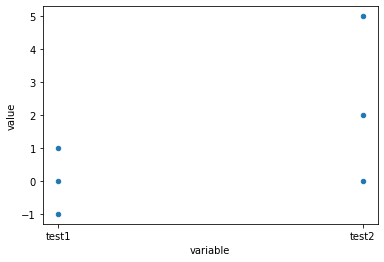

In [84]:
df.melt().plot(kind='scatter', x='variable', y='value')

In [141]:
d="""Column_A
11.2 some text 17 some text 21
some text 25.2 4.1 some text 53 17 78
121.1 bla bla bla 14 some text
12 some text"""
df = g(d)
df

,Column_A
0,11.2 some text 17 some text 21
1,some text 25.2 4.1 some text 53 17 78
2,121.1 bla bla bla 14 some text
3,12 some text


In [147]:
listA, listB, listC, listD = df.Column_A.str.findall(r"[-+]?\d*\.\d+|\d+")


['11.2', '17', '21']

In [94]:
listA=list()
listA[0] = 11.2
listA[1] = 17
listA[2] = 21
listA

IndexError: list assignment index out of range

In [128]:
import pandas as pd
import numpy as np
d = {'fruit': ['apple', 'pear', 'peach'] * 5, 'values': np.random.randint(0,1000,15)}
df = pd.DataFrame(data=d)

d2 = {'fruit': ['apple', 'pear', 'peach'], 'min': np.random.randint(0,1000,3), 'max': np.random.randint(0,1000,3)}
df2 = pd.DataFrame(data=d2)
df

,fruit,values
0,apple,296
1,pear,362
2,peach,823
3,apple,883
4,pear,753
5,peach,280
6,apple,805
7,pear,871
8,peach,937
9,apple,932


In [129]:
df2

,fruit,min,max
0,apple,467,947
1,pear,894,646
2,peach,307,618


In [140]:
df3 = df.merge(df2, on='fruit', how='inner')
df3 = df3.loc[(df3['min'] < df3['values']) & (df3['max'] > df3['values'])]
df3

,fruit,values,min,max
1,apple,883,467,947
2,apple,805,467,947
3,apple,932,467,947
4,apple,665,467,947
13,peach,331,307,618


In [136]:
df3 = df3.drop(columns=['min', 'max'])
df3

,fruit,values
3,apple,883
6,apple,805
9,apple,932
11,peach,331
12,apple,665


In [150]:
df = pd.DataFrame({'id': [12, 35, 37, 67, 99, 78],
                  'product': ['banana', 'apple', 'banana', 'pear', 'banana', 'apple'],
                  'reordered': [1, 0, 0, 1, 1, 1]})
df

,id,product,reordered
0,12,banana,1
1,35,apple,0
2,37,banana,0
3,67,pear,1
4,99,banana,1
5,78,apple,1


In [152]:
pd.crosstab(df['product'], df['reordered']).add_prefix('reordered_')\
   .assign(count=lambda x: x.sum(1))\
   .reset_index()

reordered,product,reordered_0,reordered_1,count
0,apple,1,1,2
1,banana,1,2,3
2,pear,0,1,1
